# Chapter 8: Random walks and the structure of Macromolecules


(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [22]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D # For 3D plots

# Seaborn, useful for graphics
import seaborn as sns

# Import the default plotting style
import plotting_style as pstyle
# Set plotting style
pstyle.set_plotting_style()

# Function to import and display images from the Garland website
from IPython.display import Image

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Define directories
figdir = '../fig/'

## 8.4 Binomial and Gaussian distributions

Investigate by plotting how as the number of segments $N$ of a polymer chain is increased, the binomial end-to-end distribution becomes a Gaussian distribution. Compare the different distributions in a way analogous to Figure 8.4. Also, investigate the fractional error made by approximating the binomial distribution with the Gaussian. What conclusions do you draw?

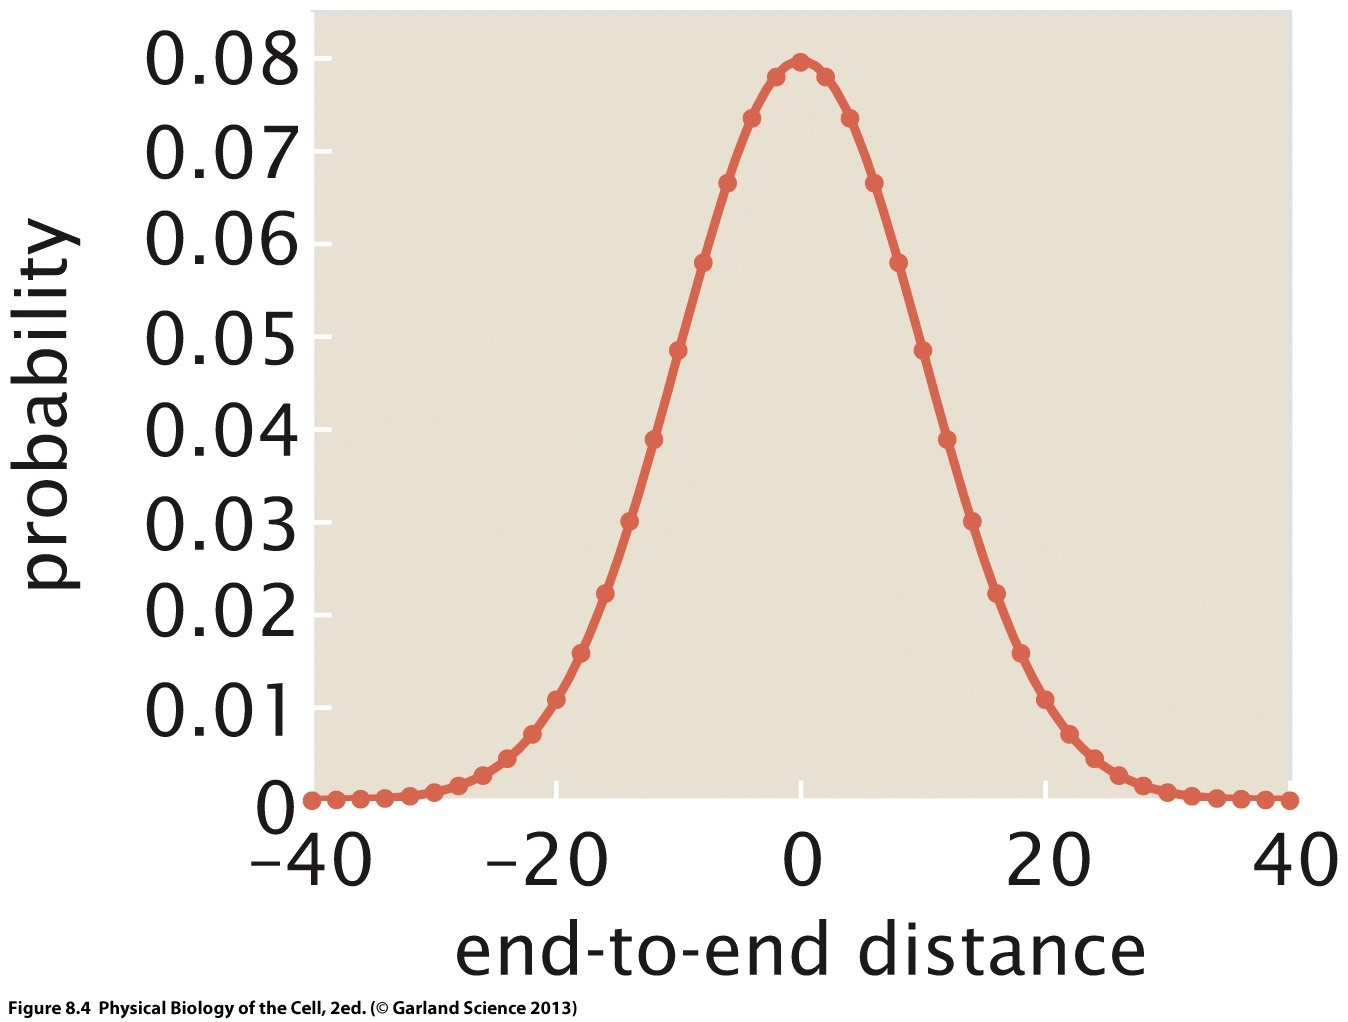

In [2]:
Image(url='http://microsite.garlandscience.com/pboc2/resources/jpegs/figures' +
      '/ch08/ch08/figure_08_04.jpg',
     embed=True, width=500, height=500)

### Solution

For a 1D polymer performing a random walk with $N$ segments the distribution of steps to the right $n_r \sim \text{Bin}(1/2, N)$. If instead we compute the distribution of the end-to-end distance $R$ this is of the form
$$
P(R \mid N) = {N! \over ({N \over 2} + {R \over 2a})! + ({N \over 2} - {R \over 2a})}
\left( {1 \over 2} \right)^N,
$$
where $a$ is the length of a single Kuhn segment. This distribution has mean zero and variance $Na^2$. This function can be simply evaluated as a Binomial distribution for even $R$ values where $n_r = (N + R / a) / 2$


In the $\lim N \rightarrow \infty$ this can be approximated as a Gaussian distribution of the form
$$
P(R \mid N) \approx {1 \over \sqrt{2\pi Na^2}} e^{- {R^2 \over 2Na^2}}.
$$

Since the Gaussian approximation is a continuous distribution it cannot be directly compared with the discrete case. To be directly comparable the probability of having an end-to-end distance $R$ where $R \in \mathbb{N}$ we need to perform an integral over the PDF. For example let's say that we want the probability of falling in $R = 8$, since $R$ can only take even number values then this will be computed as
$$
P(R = 8 \mid N) \approx \int_7^9 dR
                        {1 \over \sqrt{2\pi Na^2}} e^{- {R^2 \over 2Na^2}}
$$

This can be easily computed by taking the difference in the cumulative distribution functions (CDF) like
$$
P(R = 8 \mid N) \approx CDF(R = 7 \mid N) - CDF(R = 9 \mid N),
$$
where
$$
CDF(R = x \mid N) \equiv \int_{-\infty}^x dR
                        {1 \over \sqrt{2\pi Na^2}} e^{- {R^2 \over 2Na^2}}.
$$
Such function is already implemented in `scipy`.

In [3]:
def polymer_discrete(R, N, a=1):
    '''
    Computes the PMF evaluated at point Rfor a 1D polymer with N segments 
    of length a.
    
    Parameters
    ----------
    R : array-like.
        en-to-end distance.
    N : int.
        Number of Kuhn segments in polymer
    a : float.
        Length of each Kuhn segment
    '''
    return sp.stats.binom.pmf(((N + R / a) / 2).astype(int), N, 1 / 2)
    
def polymer_continuous(R, N, a=1):
    '''
    Computes the Gaussian PDF evaluated at point R for a 1D polymer with 
    N segments of length a.
    
    Parameters
    ----------
    R : array-like.
        en-to-end distance.
    N : int.
        Number of Kuhn segments in polymer
    a : float.
        Length of each Kuhn segment
    '''
    cdf_top = sp.stats.norm.cdf(R + 1, loc=0, scale=np.sqrt(N * a**2))
    cdf_bottom = sp.stats.norm.cdf(R - 1, loc=0, scale=np.sqrt(N * a**2))
    return cdf_top - cdf_bottom

Having coded this let's now compare the distribution for different values of $N$.

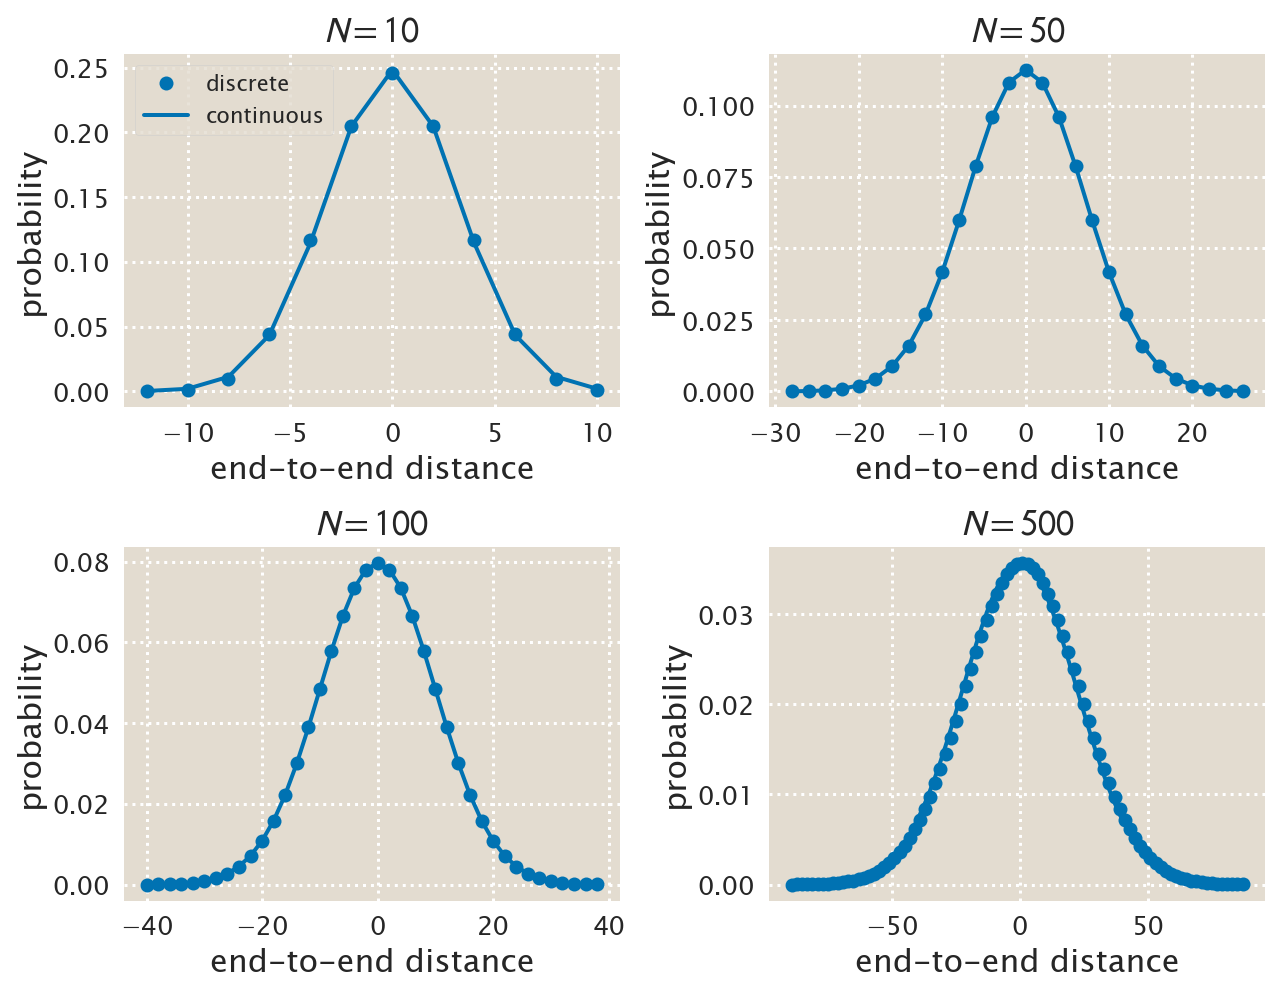

In [4]:
# Define values of N to be evaluated
N_array = [10, 50, 100, 500]

# Define the value of a
a = 1 # a.u.

# Define color for plot
color = sns.color_palette('colorblind', n_colors=1)[0]

# Initialize figure with 4 panels
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax = ax.ravel() # Flatten the ax array to be 1D rather than 2D

# Loop through each N evaluating the distributions
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Plot distributions on top of each other
    ax[i].plot(R, PMF, marker='o', lw=0, label='discrete', color=color)
    ax[i].plot(R, PDF, label='continuous', color=color)
    
    # Label plot
    ax[i].set_xlabel('end-to-end distance')
    ax[i].set_ylabel(r'probability')
    ax[i].set_title(r'$N = {:d}$'.format(N))
    

ax[0].legend()
plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_01.png', bbox_inches='tight')

To investigate the error we will compute the following quantity for different values of $N$
$$
\text{cumulative error} = \sqrt{\sum_R \left( P_d(R \mid N) -
                                       P_c(R \mid N) \right)^2}
$$ 
where $P_d$ is the discrete probability and $P_c$ the continuous.

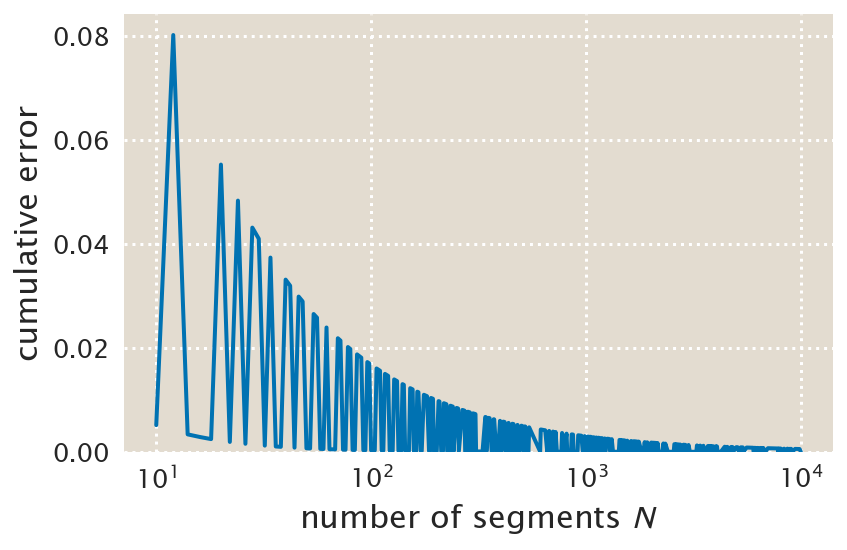

In [5]:
# Define array for N
N_array = np.unique(np.logspace(1, 4, 1000).astype(int))
N_array = [x for x in N_array if x%2 == 0]

# Initialize array to save differences
frac_error = np.zeros(len(N_array))

# Loop through each value of N
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Evaluate and save difference
    frac_error[i] = np.sqrt(np.sum((PMF - PDF)**2))

# Plot fractional error
plt.plot(N_array, frac_error)

plt.xlabel('number of segments $N$')
plt.ylabel('cumulative error')
plt.ylim(bottom=0)
plt.xscale('log')

plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_02.png', bbox_inches='tight')

There is a weird almost periodic behavior with this error that I can't explain. I would have to dig into this much more to figure it out.

Another way to study the error is the fractional error at each of the values. We define this as
$$
\text{fractional error}(R \mid N) \equiv {P_c(R \mid N) - P_d(R \mid N) \over
                                          P_d(R \mid N)},
$$
i.e. how big is the deviation at each value of $R$ for different $N$. Let's look at this quantity

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


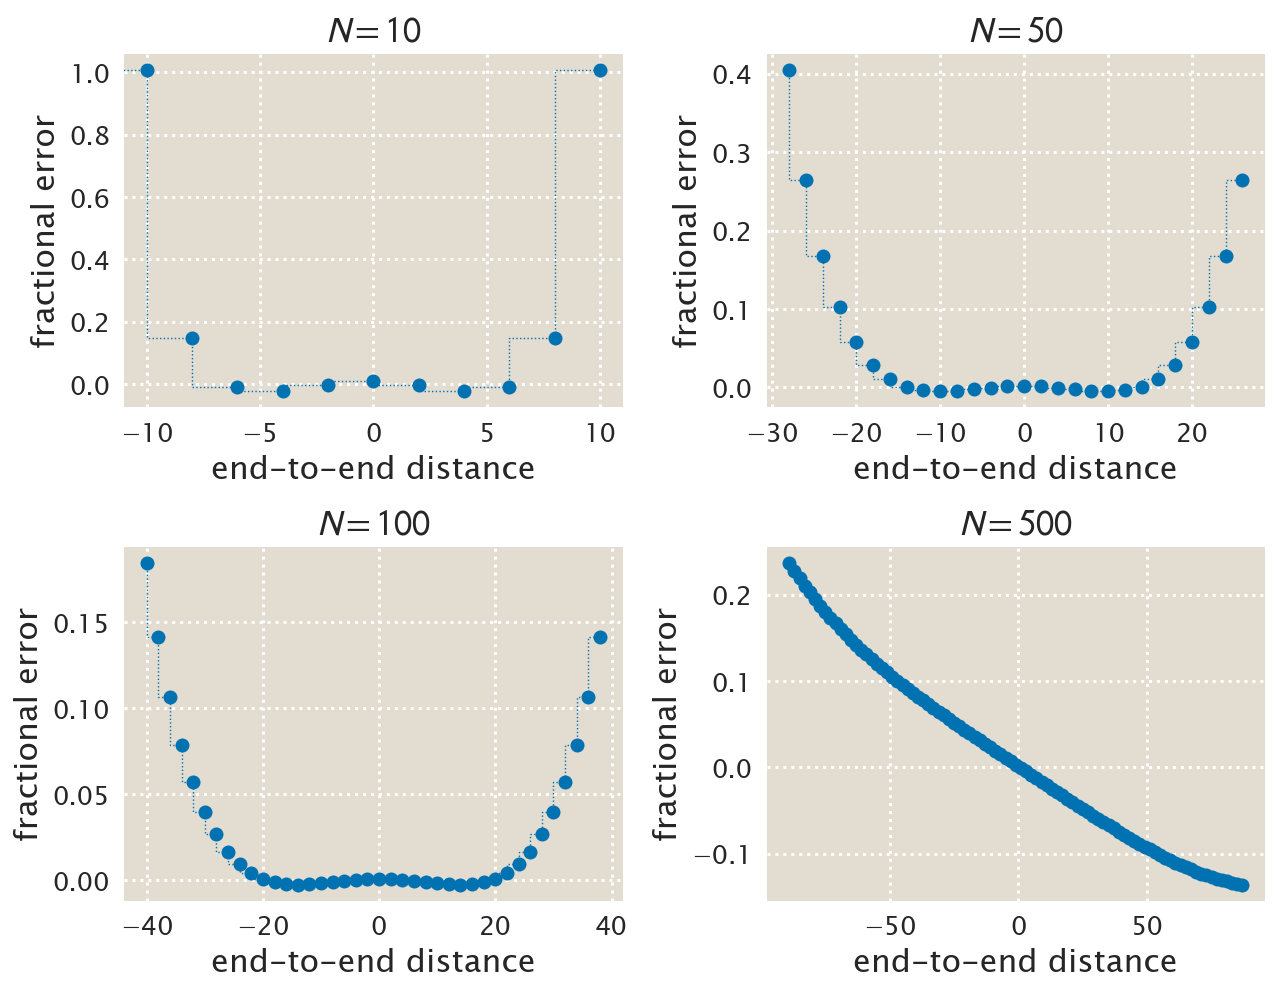

In [6]:
# Define values of N to be evaluated
N_array = [10, 50, 100, 500]

# Define the value of a
a = 1 # a.u.

# Initialize figure with 4 panels
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax = ax.ravel() # Flatten the ax array to be 1D rather than 2D

# Loop through each N evaluating the distributions
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Plot distributions on top of each other
    ax[i].plot(R, (PDF - PMF) / PMF, marker='o',
               lw=0.7, drawstyle='steps', linestyle=':')
    
    # Label plot
    ax[i].set_xlabel('end-to-end distance')
    ax[i].set_ylabel(r'fractional error')
    ax[i].set_title(r'$N = {:d}$'.format(N))
    

plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_03.png', bbox_inches='tight')

Interestingly the fractional error increases the further we move from the tails. This is most likely because at the tails the probability is very close to zero so the number explodes. But if we compute not the fractional but the absolute error this effect should disappear.

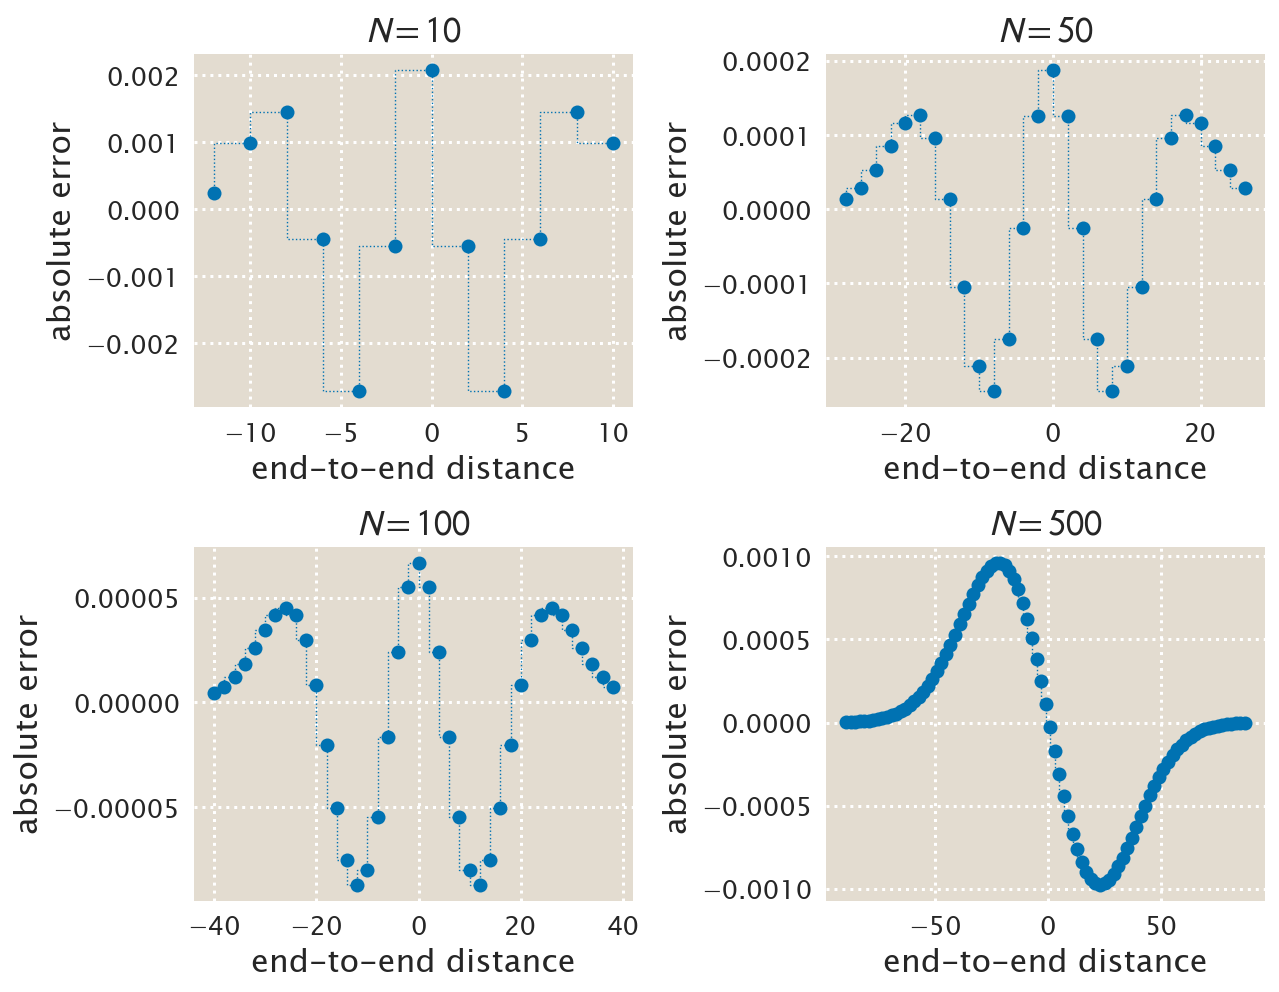

In [7]:
# Define values of N to be evaluated
N_array = [10, 50, 100, 500]

# Define the value of a
a = 1 # a.u.

# Initialize figure with 4 panels
fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax = ax.ravel() # Flatten the ax array to be 1D rather than 2D

# Loop through each N evaluating the distributions
for i, N in enumerate(N_array):
    # Select the range to evaluate the functions
    R = np.arange(int(-4 * np.sqrt(N * a**2)), 
                      int(4 * np.sqrt(N * a**2)), 2).astype(int)
    
    # Evaluate discrete dist
    PMF = polymer_discrete(R, N, a)
    # Evaluate continuous dist
    PDF = polymer_continuous(R, N, a)
    
    # Plot distributions on top of each other
    ax[i].plot(R, (PDF - PMF), marker='o',
               lw=0.7, drawstyle='steps', linestyle=':')
    
    # Label plot
    ax[i].set_xlabel('end-to-end distance')
    ax[i].set_ylabel(r'absolute error')
    ax[i].set_title(r'$N = {:d}$'.format(N))
    

plt.tight_layout()
plt.savefig(figdir + 'problem_08_04_04.png', bbox_inches='tight')

There we see that indeed the absolute value is not greater at the tails.

## 8.8 Three-dimensional random walk and polymer cyclization

Calculate the cyclization probability of a discrete random walk in one, two, and three dimensions.

### Solution

As we solve this problem for the 2D random walk we come to a point where we have to integrate a function of the form
$$
\Omega_o = \left( 1 \over 2 \pi \right)^2 \cdot 2^N
\int_{- \infty}^{\infty} d k_x \int_{- \infty}^{\infty} d k_y
\left( cos(k_x) + cos(k_y) \right)^N.
$$

Since the integral doesn't have a closed form solution let's gain some intuition for an approximation by plotting the function
$$
f(k_x, k_y, N) = \left( cos(k_x) + cos(k_y) \right)^N.
$$

In [34]:
# Define range for the x and y axis between 0 and 2π
kx = np.linspace(0, 2 * np.pi, 500)
ky = np.linspace(0, 2 * np.pi, 500)

# Generate meshgrid with these arrays
xx, yy = np.meshgrid(kx, ky)

# Define the number of segments in polymer
N = 60

# Evaluate the function
z = (np.cos(xx) + np.cos(yy))**N

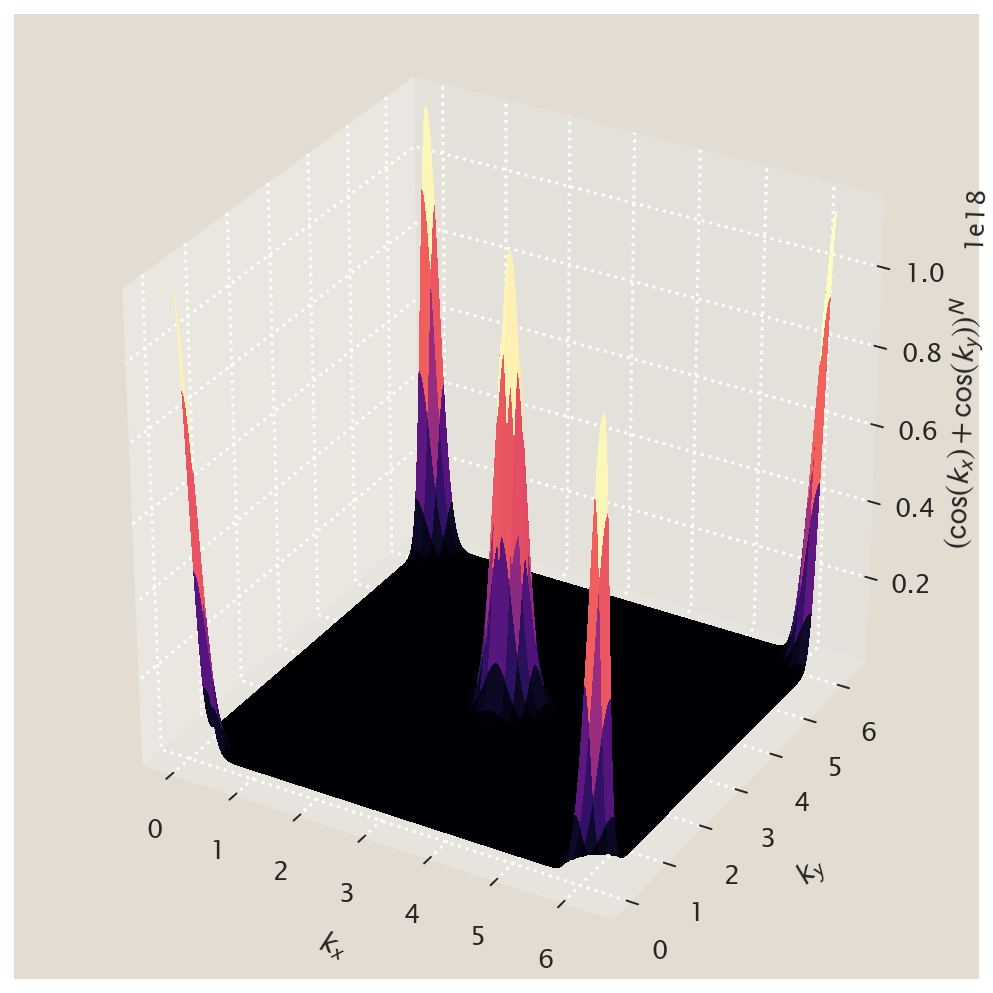

In [42]:
# Initialize 3D plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(xx, yy, z, cmap=cm.magma,
                       linewidth=1, antialiased=False)

# Label axis (and increase spacing between axis and label)
ax.set_xlabel(r'$k_x$', labelpad=15)
ax.set_ylabel(r'$k_y$', labelpad=15)
ax.set_zlabel(r'$(\cos(k_x) + \cos(k_y))^N$', labelpad=10)

# Set the background color to be white
# ax.patch.set_facecolor('white')

plt.tight_layout()
# Save figure
plt.savefig(figdir + 'problem_08_08_01.png', bbox_inches='tight')

## 8.10 Force-induced unfolding of multidomain proteins can be modeled using the random walk model

We can generalize the discussion of force–extension curves to the case of multidomain proteins. The data relevant to the particular case of the muscle protein titin has already been shown in Figure 8.22(C). The idea of the analysis we will bring to bear on this problem is shown in Figure 8.34, where it is seen that the overall contour length of the chain increases in a systematic and calculable way as a function of the number of domains that have unfolded. Use a model like that suggested in Figure 8.34 to compare with the data shown in Figure 8.22(C). Your fits to the data should focus only on the rising parts of the force–expansion curve. The relevant data can be found on the book’s website.

In [ ]:
Image(url='http://microsite.garlandscience.com/pboc2/resources/jpegs/figures' +
      '/ch08/ch08/figure_08_34.jpg',
     embed=True, width=500, height=500)

### Solution

To start exploring this problem let's first import the data.

In [10]:
# Read excel file
df = pd.read_excel('../data/fig8.22.xls', comment='#')
df.head()

,extension_nm,force_pN
0,57.917773,31.712290
1,58.758533,31.712290
2,59.599293,33.736339
3,60.440053,34.632855
4,61.280813,38.910293


Let's now plot the raw data.

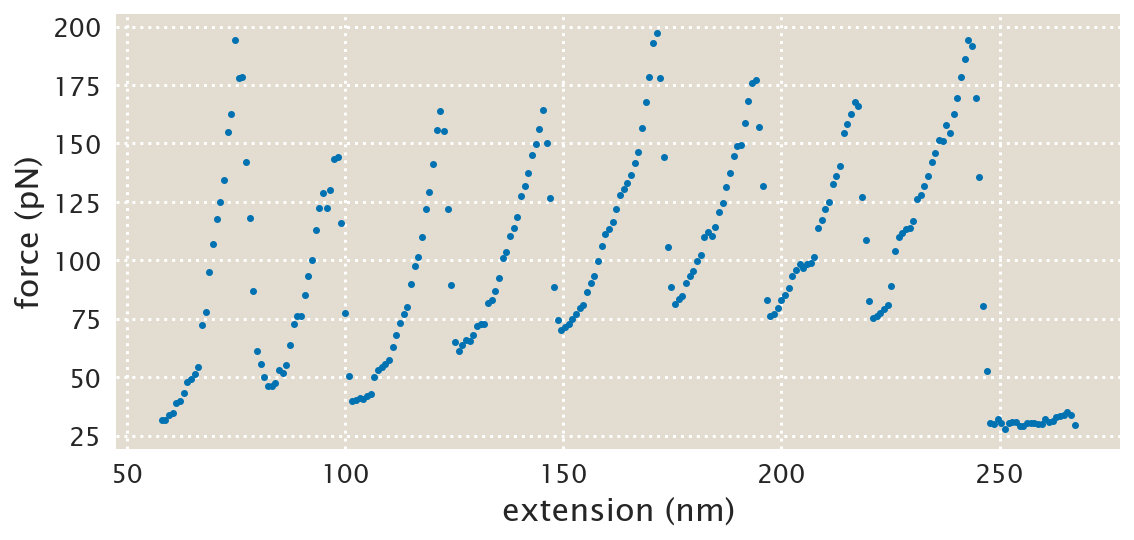

In [19]:
# Plot data using Pandas function (very convenient)
df.plot('extension_nm', 'force_pN', marker='.', lw=0, legend=False,
        figsize=(9, 4))

# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')

In order to find whwere the peaks are we will filter the data to smooth it. For this we will apply a [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) to the data.

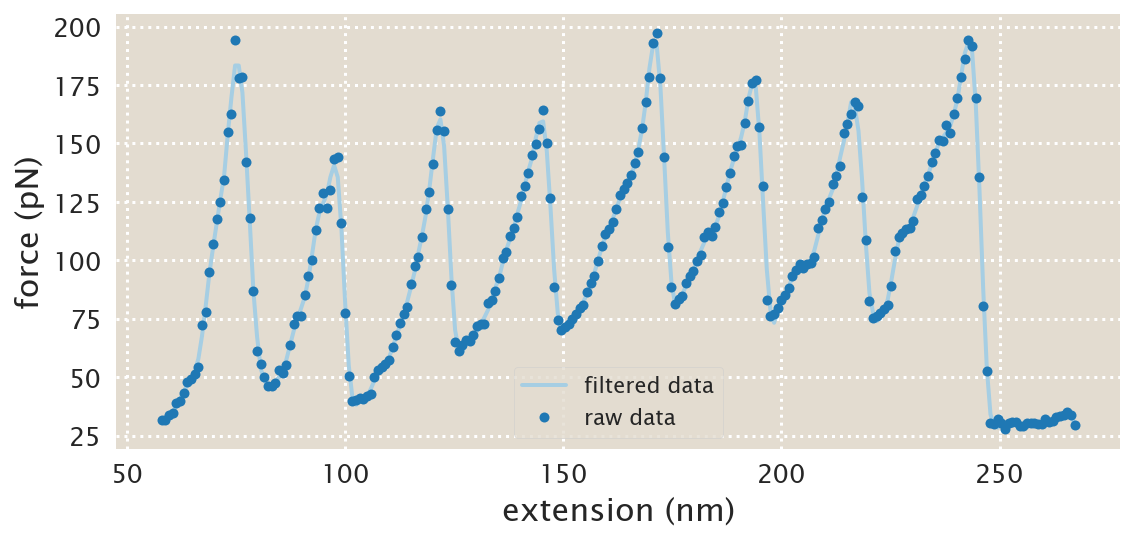

In [82]:
# Apply smoothing filter
df['force_filter'] = scipy.signal.savgol_filter(df.force_pN.values, 7, 2)

# Define colors for plot
colors = sns.color_palette('Paired', n_colors=2)

fig = plt.figure(figsize=(9, 4))
# Plot smooth data and raw data
plt.plot(df.extension_nm, df.force_filter, color=colors[0], 
         label='filtered data')
plt.plot(df.extension_nm, df.force_pN, color=colors[1], marker='.', markersize=10,
         lw=0, label='raw data')

plt.legend()
# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')

Having smooth the data let's find the local maxima and minima

In [83]:
# Find maxima and minima using scipy signal
max_idx = scipy.signal.argrelmax(df.force_filter.values)
min_idx = scipy.signal.argrelmin(df.force_filter.values)

# Initialize boolean array to have as an index of whether or not a point is
# an extrema
bool_idx = np.zeros(len(df), dtype=bool)

# Convert index into a Boolean statement
bool_idx[max_idx] = True
bool_idx[min_idx] = True

# Add boolean index to dataframe
df['extrema_idx'] = bool_idx

Let's see how well we did at finding the peaks

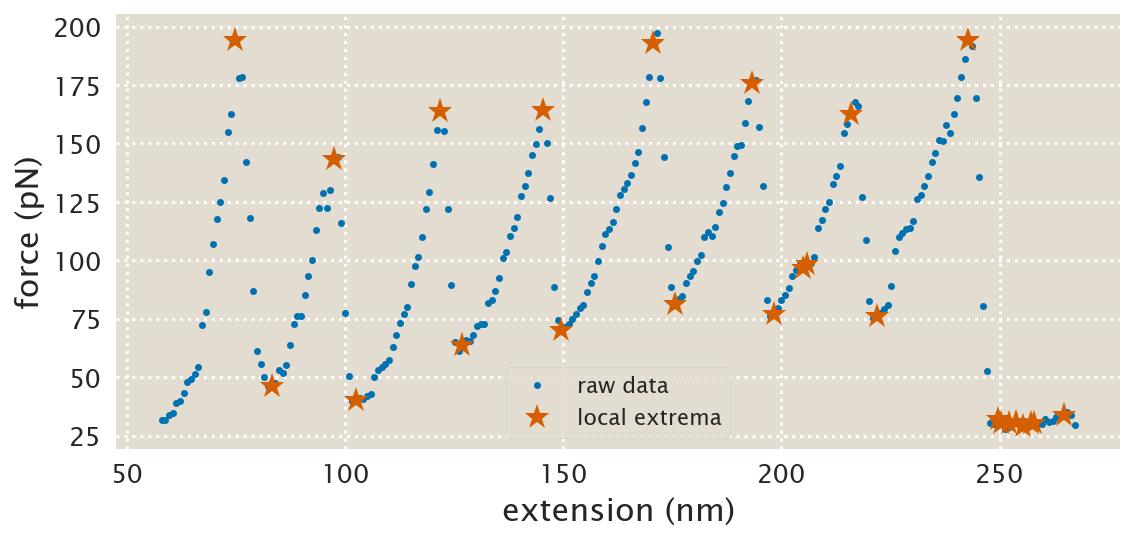

In [88]:
# Plot data using Pandas function (very convenient)
df.plot('extension_nm', 'force_pN', marker='.', lw=0, legend=False,
        figsize=(9, 4), label='raw data')

plt.plot(df[df.extrema_idx == True].extension_nm, 
         df[df.extrema_idx == True].force_pN, marker='*', markersize='13', lw=0,
         color='r', label='local extrema')

# Label axis
plt.xlabel('extension (nm)')
plt.ylabel('force (pN)')
plt.legend()

Not too bad. Especially for the first peaks. There are a couple of errors at the end, but in general it looks good.